<a href="https://colab.research.google.com/github/RodrigoRoman/machine_learning_abc/blob/main/multilayer_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Activity 1a: Implementing a Multilayer Fully Connected Network using Numpy

*   Instructions

 - Read and Understand the following Code: The provided starter code outlines the architecture of a Fully Connected Network designed to classify MNIST images. Go through the code to understand how each function and class is used to implement the network.

  - Understand the Math: Make sure you understand the math operations implemented in the code, especially during the forward and backward passes. This will involve matrix multiplications, activation functions, loss computations, and backpropagation.

* Experiment You are encouraged to play with the code, change any hyperparameters and train the model, you should be able to achieve over 95% accuracy on the test set without problems.

In [26]:
import gzip
import os
from os.path import isfile, join
import numpy as np
import requests
import matplotlib.pyplot as plt



In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
import os
mnist_path = "/content/drive/My Drive/Colab Notebooks/mnist_raw/"
os.chdir(mnist_path)


def list_files(mnist_path):
    return [join(mnist_path,f) for f in os.listdir(mnist_path) if isfile(join(mnist_path, f))]

for f in list_files(mnist_path):
    print(f)


/content/drive/My Drive/Colab Notebooks/mnist_raw/train-labels-idx1-ubyte.gz
/content/drive/My Drive/Colab Notebooks/mnist_raw/t10k-labels-idx1-ubyte.gz
/content/drive/My Drive/Colab Notebooks/mnist_raw/t10k-images-idx3-ubyte.gz
/content/drive/My Drive/Colab Notebooks/mnist_raw/train-images-idx3-ubyte.gz



Define a function get_images that will allow us to convert the data that comes from MNIST to data that we can use directly into numpy

In [29]:
def get_images(mnist_path):
  for f in list_files(mnist_path):
    if 'train-images' in f:
      with gzip.open(f,'rb') as data:
        _= int.from_bytes(data.read(4),'big') #dummy read
        num_images = int.from_bytes(data.read(4),'big')
        rows = int.from_bytes(data.read(4),'big')
        columns = int.from_bytes(data.read(4),'big')
        train_images = data.read()
        x_train = np.frombuffer(train_images,dtype=np.uint8)
        x_train = x_train.reshape((num_images,rows,columns))
    elif 'train-labels' in f:
      with gzip.open(f,'rb') as data:
        train_labels = data.read()[8::]
        y_train = np.frombuffer(train_labels,dtype = np.uint8)
    if 't10k-images' in f:
      with gzip.open(f,'rb') as data:
        _= int.from_bytes(data.read(4),'big') #dummy read
        num_images = int.from_bytes(data.read(4),'big')
        rows = int.from_bytes(data.read(4),'big')
        columns = int.from_bytes(data.read(4),'big')
        test_images = data.read()
        x_test = np.frombuffer(test_images,dtype=np.uint8)
        x_test = x_test.reshape((num_images,rows,columns))
    elif 't10k-labels' in f:
      with gzip.open(f,'rb') as data:
        test_labels = data.read()[8::]
        y_test= np.frombuffer(test_labels,dtype = np.uint8)

  return x_train,y_train,x_test,y_test




Let's apply our get_images function to the MNIST data

In [30]:
x_train_num,y_train_num,x_test_num,y_test_num = get_images(mnist_path)

We check that our data corresponds to the specifications from the MNIST documentation

In [31]:
print(x_train_num.shape)
print(x_test_num.shape)
print(y_train_num.shape)
print(y_test_num.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


We can graph some instance numbers from our dataset

La imagen mostrada corresponse a un:3


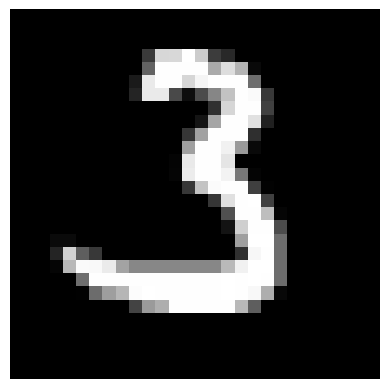

In [32]:
def plot_number(image):
  plt.imshow(image.squeeze(),cmap=plt.get_cmap('gray'))
  plt.axis('off')

rand_idx = np.random.randint(len(y_test_num))
print(f'La imagen mostrada corresponse a un:{y_test_num[rand_idx]}')
plot_number(x_test_num[rand_idx])


# 2 layer neural network algorithm

Convert images to vectors and float32

In [36]:
x_train = x_train_num[:50000].reshape(50000,-1).astype(np.float32)/255 # -1 is equivalent to 28X28 in this case
y_train = y_train_num[:50000].reshape(50000,-1)

x_val = x_train_num[50000:].reshape(10000,-1).astype(np.float32)/255
y_val = y_train_num[50000:].reshape(10000,1)

x_test = x_test_num.copy().reshape(10000,-1).astype(np.float32)/255
y_test = y_test_num.copy().reshape(10000,1)

print(x_train.shape) #shape (50000, 784)
print(y_train.shape) #shape (50000, 1)

print(x_val.shape)
print(y_val.shape)

print(x_test.shape) #shape (10000, 784)
print(y_test.shape) #shape (10000, 1)



(50000, 784)
(50000, 1)
(10000, 784)
(10000, 1)
(10000, 784)
(10000, 1)


Each input data to our model will have a shape of 784, the output layer will have 10 neurons.

Our activation function will be ReLU

We will not input the 50,000 data points all at once. Instead, it is more efficien if we use mini batches. For that we need to reduce the size of the amount of data that gets into the model.

In [37]:
def create_minibatches(mbSize,x,y,shuffle=True):
  assert x.shape[0] == y.shape[0], 'Error in amount of samples'
  totalData = x.shape[0]
  if shuffle:
    idxs = np.arange(totalData)
    np.random.shuffle(idxs)
    x = x[idxs]
    y = y[idxs]
  return ((x[i:i+mbSize],y[i:i+mbSize])for i in range(0,totalData,mbSize))

Init parameters (weight and height)

In [41]:
def init_parameters(inputSize, neurons):
  '''
  inputSize -> input elements, 784
  neurons -> list[200,10] with amount of neurons by layer
  '''
  w1 = np.random.randn(neurons[0],inputSize) * 0.001 #Will return a list of numbers between 0 and 0.001
  b1 = np.zeros((neurons[0],1))

  w2 = np.random.randn(neurons[1],neurons[0]) * 0.001
  b2 = np.zeros((neurons[1],1))
  return {'w1':w1,'b1':b1,'w2':w2,'b2':b2}

parameters = init_parameters(28*28,[200,10])

In [42]:
def relu(x):
  return np.maximum(0,x)

In [43]:
def scores(x,parameters,activationFunction):
  z1 = parameters['w1'] @ x +parameters['b1']
  a1 = activationFunction(z1) #Activation function output
  z2 = parameters['w2'] @ a1 + parameters['b2']

  return z2,z1,a1

scores, z1,a1 = scores(x_train[:64].T,parameters,relu)

In [ ]:
def softmax(x):
  exp_scores = np.exp(x)
  sum_exp_scores = np.sum(exp_scores,axis=0)
  probs = exp_scores/sum_exp_scores
  return probs

def x_entropy(scores,y,batch_size=64):
  probs = softmax(scores)
  y_hat = probs[y.squeeze(),np.arange(batch_size)]
  cost = np.sum(-np.log(y_hat))/batch_size
  return probs, cost


y_train.squeeze()